In [40]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.signal import detrend
from astropy.timeseries import LombScargle
from scipy.stats import norm
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch
import xarray as xr


Latitude range: (53.123863, 53.156006)
Longitude range: (6.413006, 6.4673705)
Converted coordinates for InSAR range:
(6.413005828857422, 53.123863220214844) -> (183261.73337120007, 260892.29508686066)
(6.467370510101318, 53.156005859375) -> (189306.80726764188, 266850.48666438553)


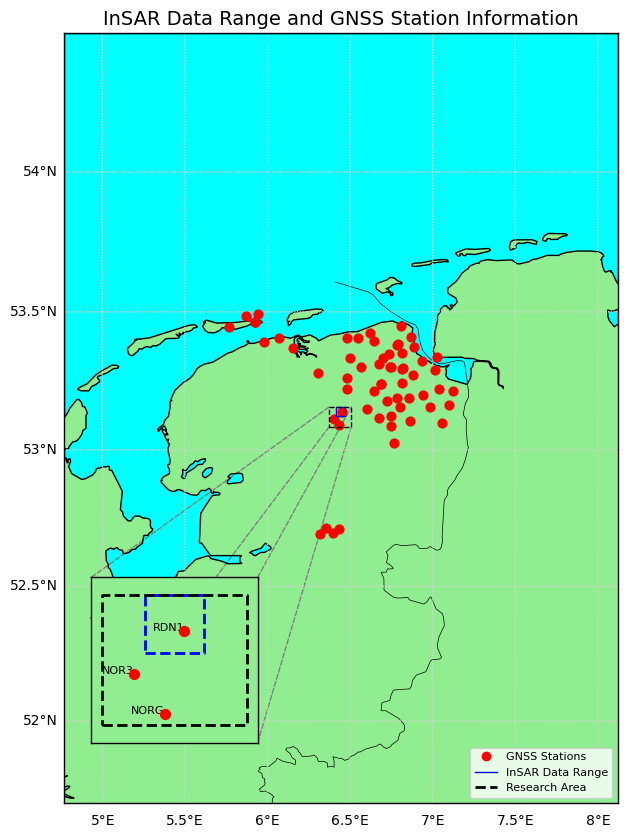

In [41]:
# Load MAT file
file_path = '06gps_nam_2006-2024.mat'
mat_data = scipy.io.loadmat(file_path)

# Extract station coordinates
pntCrd = mat_data['pntCrd']
latitudes = pntCrd[:, 0]
longitudes = pntCrd[:, 1]

# Load station names
pntName = mat_data['pntName']

# Load InSAR data file
insar_file_path = 's1_dsc_t037_v2.nc'
insar_data = xr.open_dataset(insar_file_path)

# Extract latitude and longitude range
latitudes_insar = insar_data['lat'].values
longitudes_insar = insar_data['lon'].values
latitude_range = (latitudes_insar.min(), latitudes_insar.max())
longitude_range = (longitudes_insar.min(), longitudes_insar.max())
print('Latitude range:', latitude_range)
print('Longitude range:', longitude_range)

# Determine the study area range, slightly larger than the InSAR area
interest_lat_range = (latitude_range[0] - 0.04, latitude_range[1])
interest_lon_range = (longitude_range[0] - 0.04, longitude_range[1] + 0.04)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Create Basemap instance
m = Basemap(projection='merc', 
            llcrnrlat=min(latitudes.min(), latitude_range[0]) - 1, 
            urcrnrlat=max(latitudes.max(), latitude_range[1]) + 1,
            llcrnrlon=min(longitudes.min(), longitude_range[0]) - 1, 
            urcrnrlon=max(longitudes.max(), longitude_range[1]) + 1,
            resolution='h', ax=ax)

# Draw coastlines and country borders, fill colors
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgreen', lake_color='aqua')
m.drawmapboundary(fill_color='aqua')
# Add latitude and longitude labels, set color to light gray
parallels = np.arange(int(latitudes.min()) - 1, int(latitudes.max()) + 2, 0.5)
meridians = np.arange(int(longitudes.min()) - 1, int(longitudes.max()) + 2, 0.5)
m.drawparallels(parallels, labels=[1,0,0,0], fontsize=10, color='lightgrey')
m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10, color='lightgrey')

# Convert InSAR data range to map projection coordinates
x0, y0 = m(longitude_range[0], latitude_range[0])
x1, y1 = m(longitude_range[1], latitude_range[1])

# Debug information: check converted coordinates
print('Converted coordinates for InSAR range:')
print(f'({longitude_range[0]}, {latitude_range[0]}) -> ({x0}, {y0})')
print(f'({longitude_range[1]}, {latitude_range[1]}) -> ({x1}, {y1})')

# Convert GNSS station latitudes and longitudes to map projection coordinates
x, y = m(longitudes, latitudes)

# Plot GNSS stations
m.scatter(x, y, color='red', marker='o', s=40, zorder=5, label='GNSS Stations')

# Plot InSAR data range (ensure zorder value is higher)
m.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], color='blue', linestyle='-', linewidth=1, zorder=10, label='InSAR Data Range')
plt.title('InSAR Data Range and GNSS Station Information', fontsize=14)

# Convert the area of interest to map projection coordinates
x2, y2 = m(interest_lon_range[0], interest_lat_range[0])
x3, y3 = m(interest_lon_range[1], interest_lat_range[1])

# Plot the area of interest (slightly larger than the InSAR area, using dashed lines)
m.plot([x2, x3, x3, x2, x2], 
       [y2, y2, y3, y3, y2], 
color='black', linestyle='--', linewidth=1, zorder=15, label='Research Area')

# Create inset
ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower left', borderpad=2)
m_inset = Basemap(projection='merc', 
                  llcrnrlat=interest_lat_range[0] - 0.01, 
                  urcrnrlat=interest_lat_range[1] + 0.01,
                  llcrnrlon=interest_lon_range[0] - 0.01, 
                  urcrnrlon=interest_lon_range[1] + 0.01,
                  resolution='i', ax=ax_inset)

# Draw coastlines and country borders, fill colors
m_inset.drawcoastlines()
m_inset.drawcountries()
m_inset.fillcontinents(color='lightgreen', lake_color='aqua')
m_inset.drawmapboundary(fill_color='aqua')

# Convert GNSS station and InSAR data range to map projection coordinates
x_inset, y_inset = m_inset(longitudes, latitudes)
x0_inset, y0_inset = m_inset(longitude_range[0], latitude_range[0])
x1_inset, y1_inset = m_inset(longitude_range[1], latitude_range[1])

# Plot GNSS stations and InSAR area in inset
m_inset.scatter(x_inset, y_inset, color='red', marker='o', s=50, zorder=5)
m_inset.plot([x0_inset, x1_inset, x1_inset, x0_inset, x0_inset], 
             [y0_inset, y0_inset, y1_inset, y1_inset, y0_inset], 
             color='blue', linestyle='--', linewidth=2, zorder=10)

# Plot area of interest in inset
x2_inset, y2_inset = m_inset(interest_lon_range[0], interest_lat_range[0])
x3_inset, y3_inset = m_inset(interest_lon_range[1], interest_lat_range[1])
m_inset.plot([x2_inset, x3_inset, x3_inset, x2_inset, x2_inset], 
             [y2_inset, y2_inset, y3_inset, y3_inset, y2_inset], 
             color='black', linestyle='--', linewidth=2, zorder=15)

# Label station names in inset
for i, name in enumerate(pntName):
    name_str = str(name[0][0])
    if (interest_lon_range[0] <= longitudes[i] <= interest_lon_range[1]) and (interest_lat_range[0] <= latitudes[i] <= interest_lat_range[1]):
        ax_inset.text(x_inset[i], y_inset[i], name_str, fontsize=8, ha='right', color='black')

# Get the coordinates of the four corners of the main plot and the inset
corners_main = [(x2, y2), (x3, y2), (x3, y3), (x2, y3)]
corners_inset = [ax_inset.transData.inverted().transform(ax_inset.transAxes.transform((0, 0))),
                 ax_inset.transData.inverted().transform(ax_inset.transAxes.transform((1, 0))),
                 ax_inset.transData.inverted().transform(ax_inset.transAxes.transform((1, 1))),
                 ax_inset.transData.inverted().transform(ax_inset.transAxes.transform((0, 1)))]

# Draw connection lines between main plot and inset
for (x_main, y_main), (x_ins, y_ins) in zip(corners_main, corners_inset):
    con = ConnectionPatch(xyA=(x_ins, y_ins), xyB=(x_main, y_main),
                          coordsA='data', coordsB='data',
                          axesA=ax_inset, axesB=ax, color='gray', linestyle='--')
    ax.add_artist(con)

# Add legend
gnss_legend = plt.Line2D((0,1),(0,0), color='red', marker='o', linestyle='', markersize=6, label='GNSS Stations')
insar_legend = plt.Line2D((0,1),(0,0), color='blue', linestyle='-', linewidth=1, label='InSAR Data Range')
research_area_legend = plt.Line2D((0,1),(0,0), color='black', linestyle='--', linewidth=2, label='Research Area')
ax.legend(handles=[gnss_legend, insar_legend, research_area_legend], loc='lower right', fontsize=8)

plt.show()


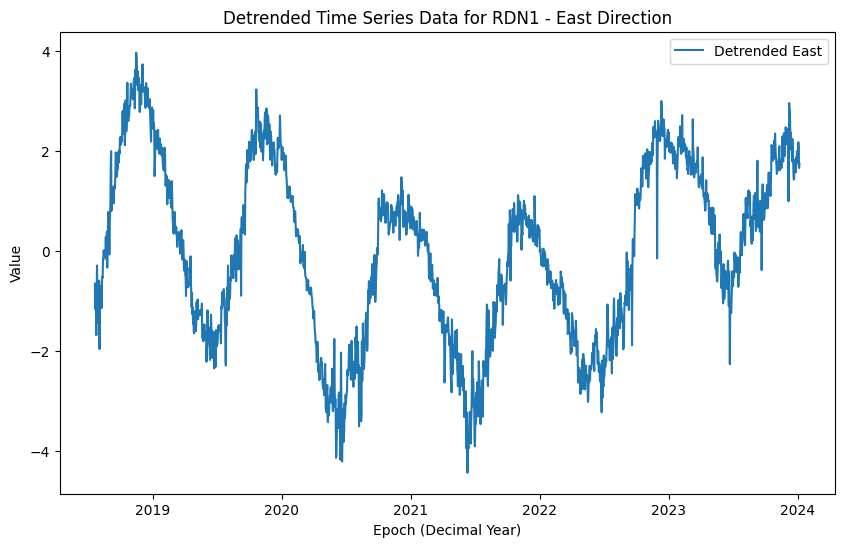

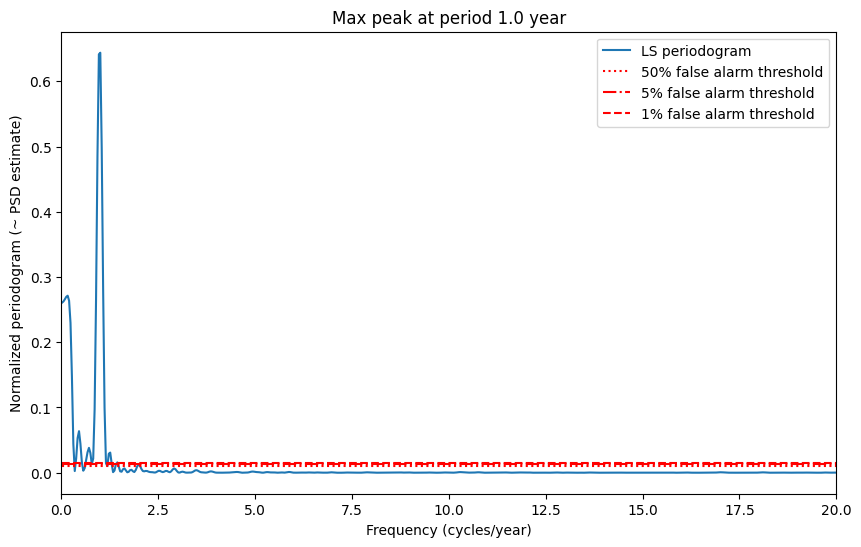

Best period for RDN1 East: 0.9930931491506437 years
Optimization terminated successfully.
         Current function value: 0.184802
         Iterations: 10
         Function evaluations: 940
                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                 1992
Model:                             local linear trend   Log Likelihood                -368.127
                   + stochastic freq_seasonal(365(1))   AIC                            750.253
                                              + AR(2)   BIC                            789.417
Date:                                Mon, 10 Jun 2024   HQIC                           764.638
Time:                                        11:38:48                                         
Sample:                                             0                                         
                                               - 

/Users/lewys/anaconda3/envs/VSP/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


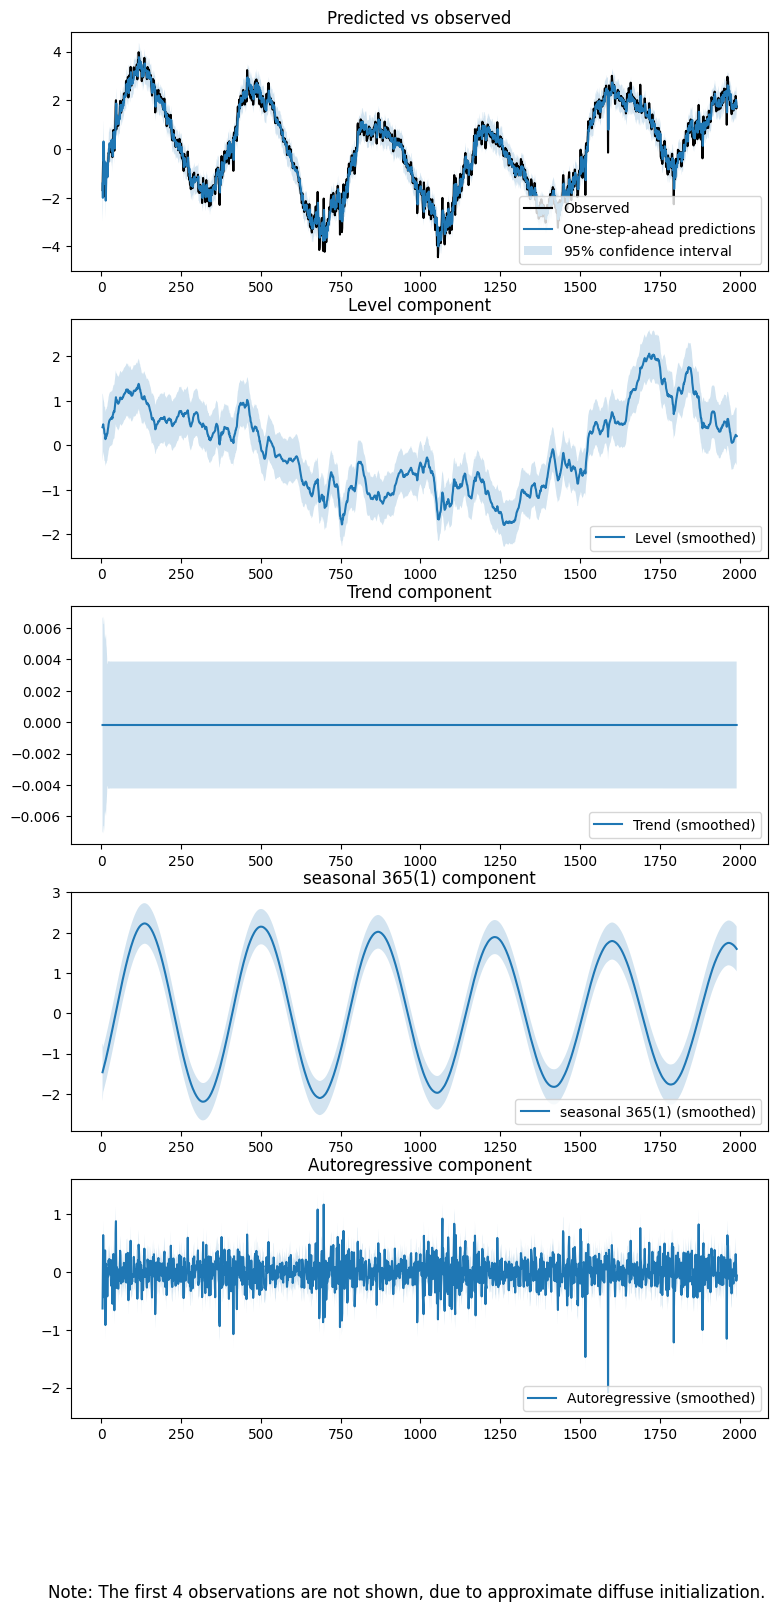

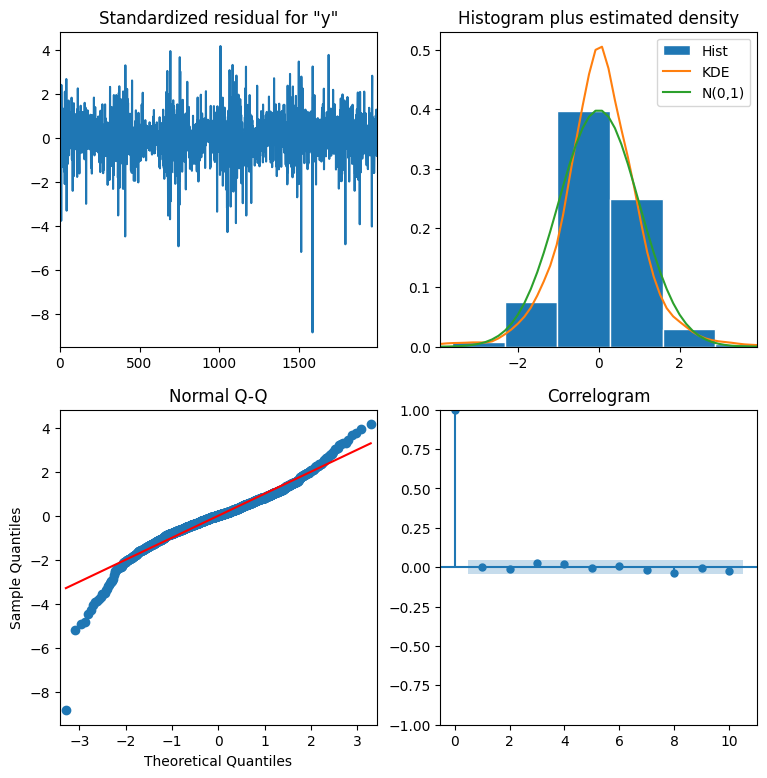

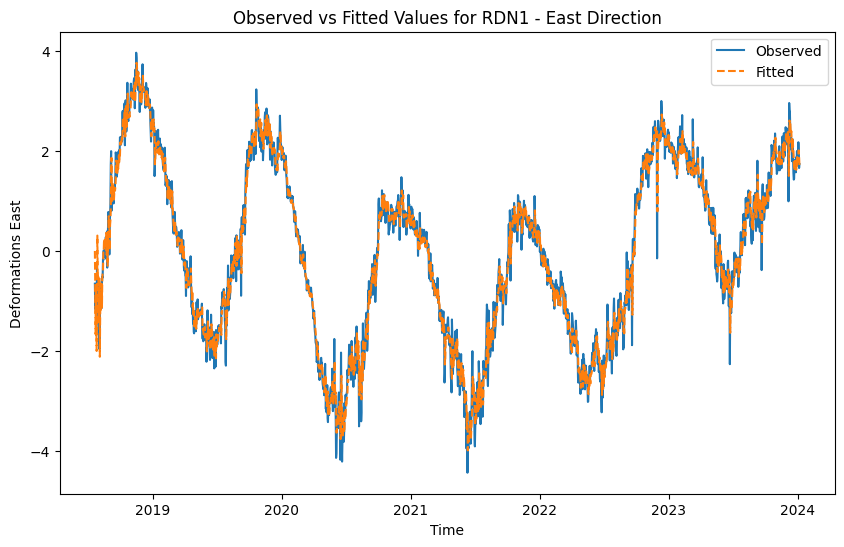

Observation equation covariance matrix (measurement noise) for RDN1 - East:
 [[[1.44492196e-09]]]
State equation covariance matrix (process noise) for RDN1 - East:
 [[[8.35597229e-03]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [3.52508778e-12]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [1.12891951e-04]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [1.12891951e-04]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [6.27204358e-02]]]
Standard deviation (sigma) of the residuals for RDN1 - East: 0.2946294552800417


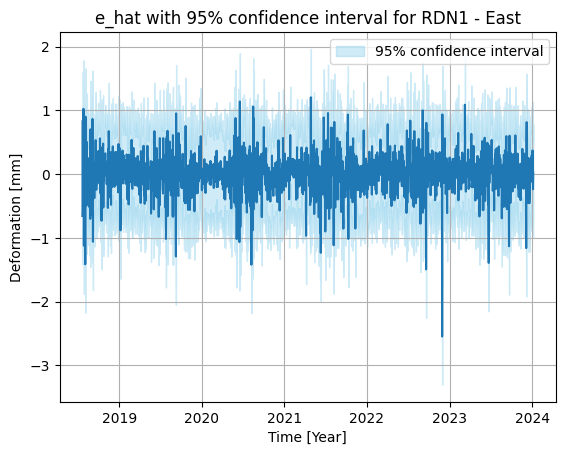

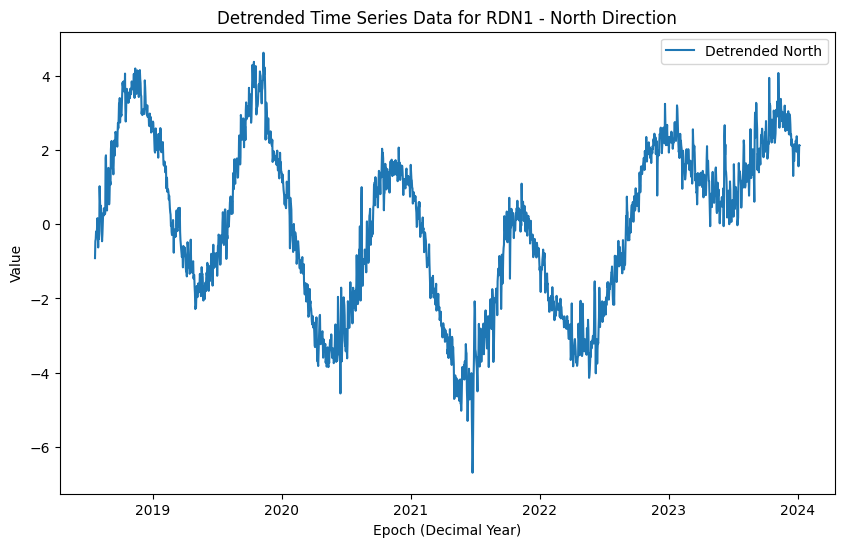

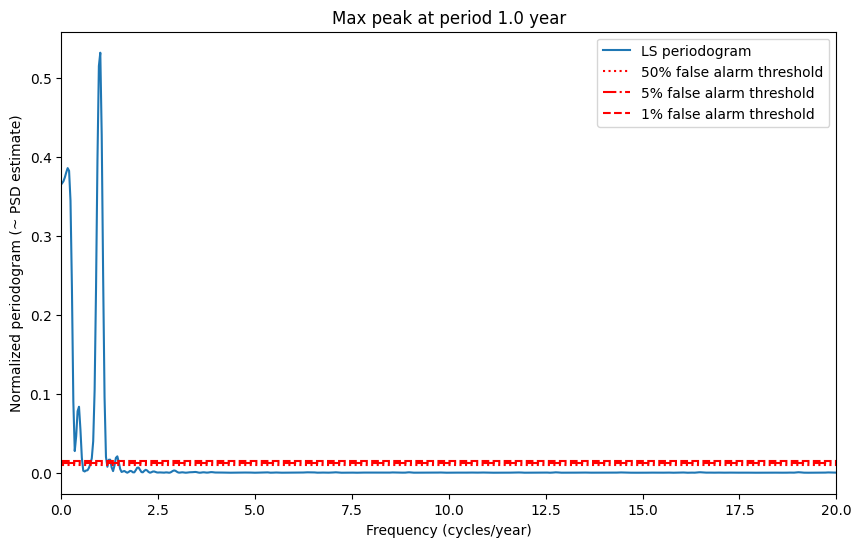

Best period for RDN1 North: 0.9930931491506437 years
Optimization terminated successfully.
         Current function value: 0.334751
         Iterations: 7
         Function evaluations: 633
                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                 1992
Model:                             local linear trend   Log Likelihood                -666.824
                   + stochastic freq_seasonal(365(1))   AIC                           1347.649
                                              + AR(2)   BIC                           1386.813
Date:                                Mon, 10 Jun 2024   HQIC                          1362.034
Time:                                        11:38:50                                         
Sample:                                             0                                         
                                               - 

/Users/lewys/anaconda3/envs/VSP/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


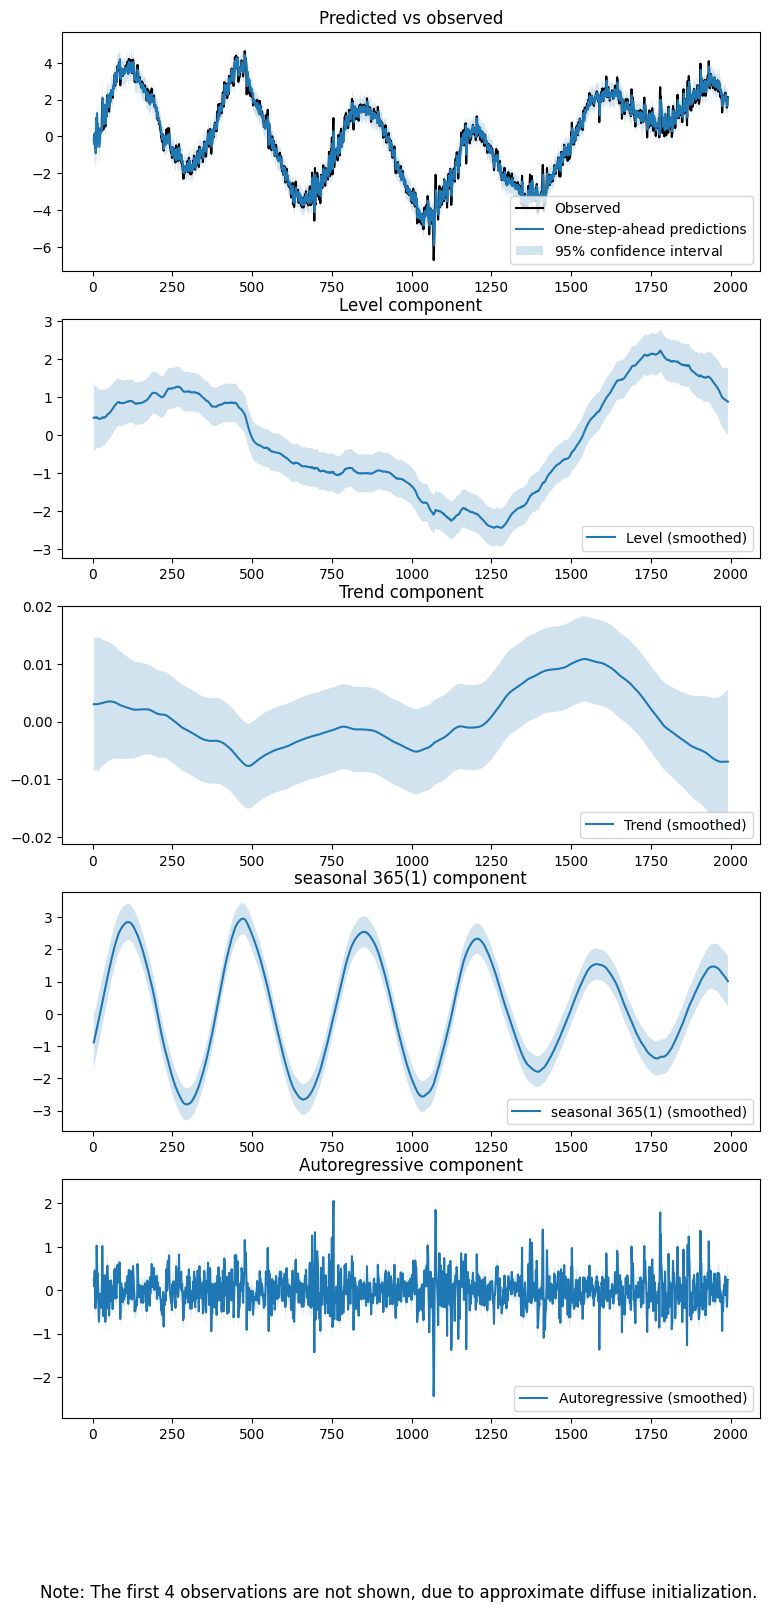

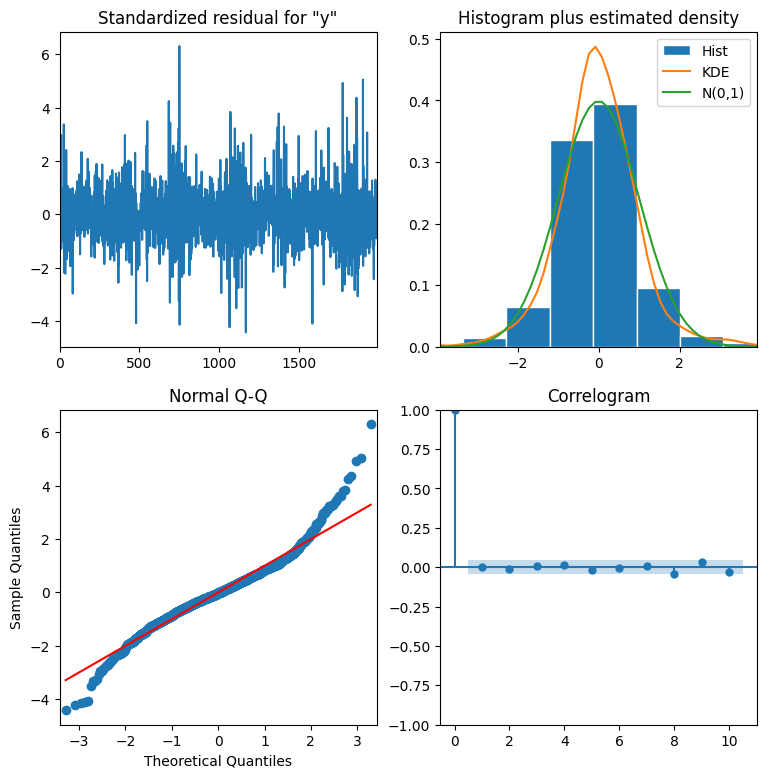

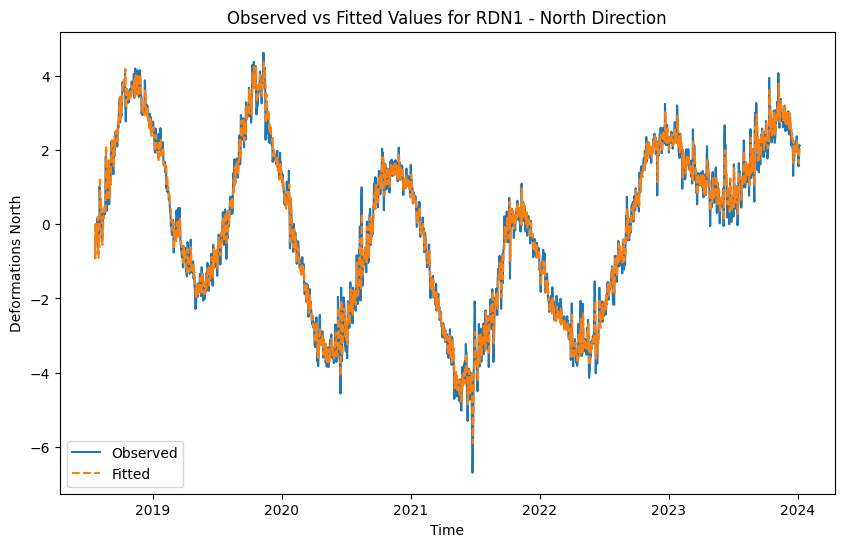

Observation equation covariance matrix (measurement noise) for RDN1 - North:
 [[[3.69955617e-10]]]
State equation covariance matrix (process noise) for RDN1 - North:
 [[[1.76458213e-03]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [3.33717890e-07]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [7.10781842e-04]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [7.10781842e-04]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [1.01196089e-01]]]
Standard deviation (sigma) of the residuals for RDN1 - North: 0.33940533537900547


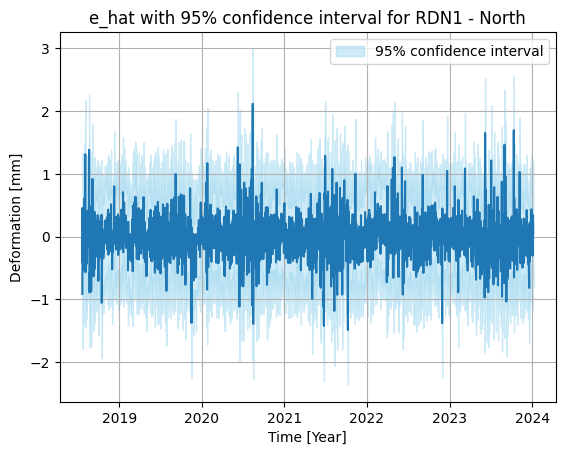

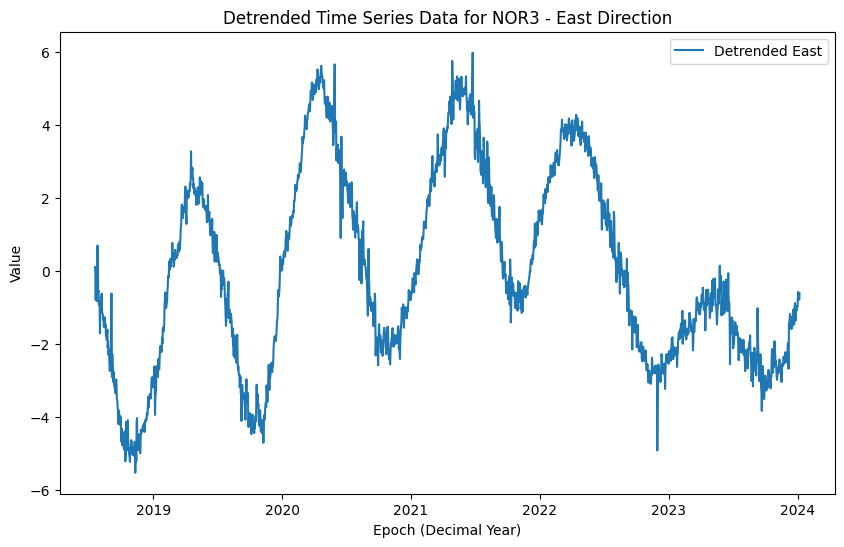

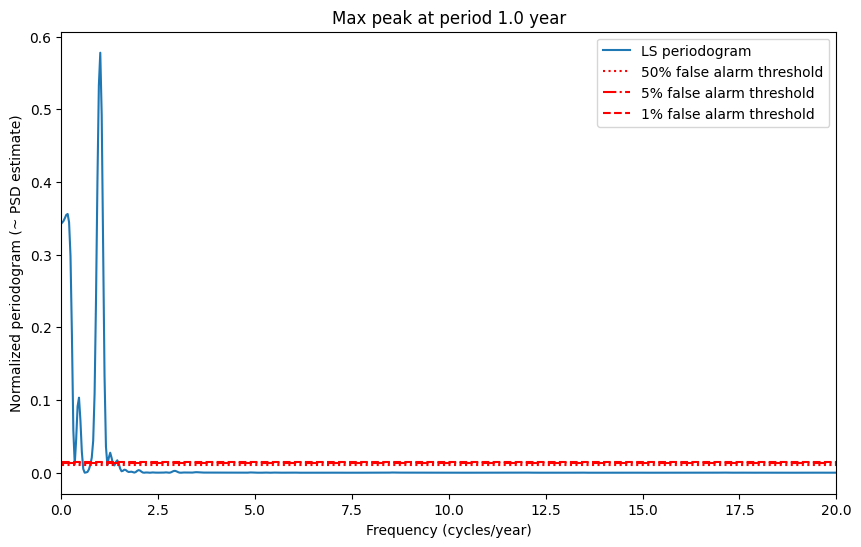

Best period for NOR3 East: 0.9935909402028383 years
Optimization terminated successfully.
         Current function value: 0.188654
         Iterations: 8
         Function evaluations: 774
                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                 1995
Model:                             local linear trend   Log Likelihood                -376.365
                   + stochastic freq_seasonal(365(1))   AIC                            766.730
                                              + AR(2)   BIC                            805.905
Date:                                Mon, 10 Jun 2024   HQIC                           781.118
Time:                                        11:38:52                                         
Sample:                                             0                                         
                                               - 1

/Users/lewys/anaconda3/envs/VSP/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


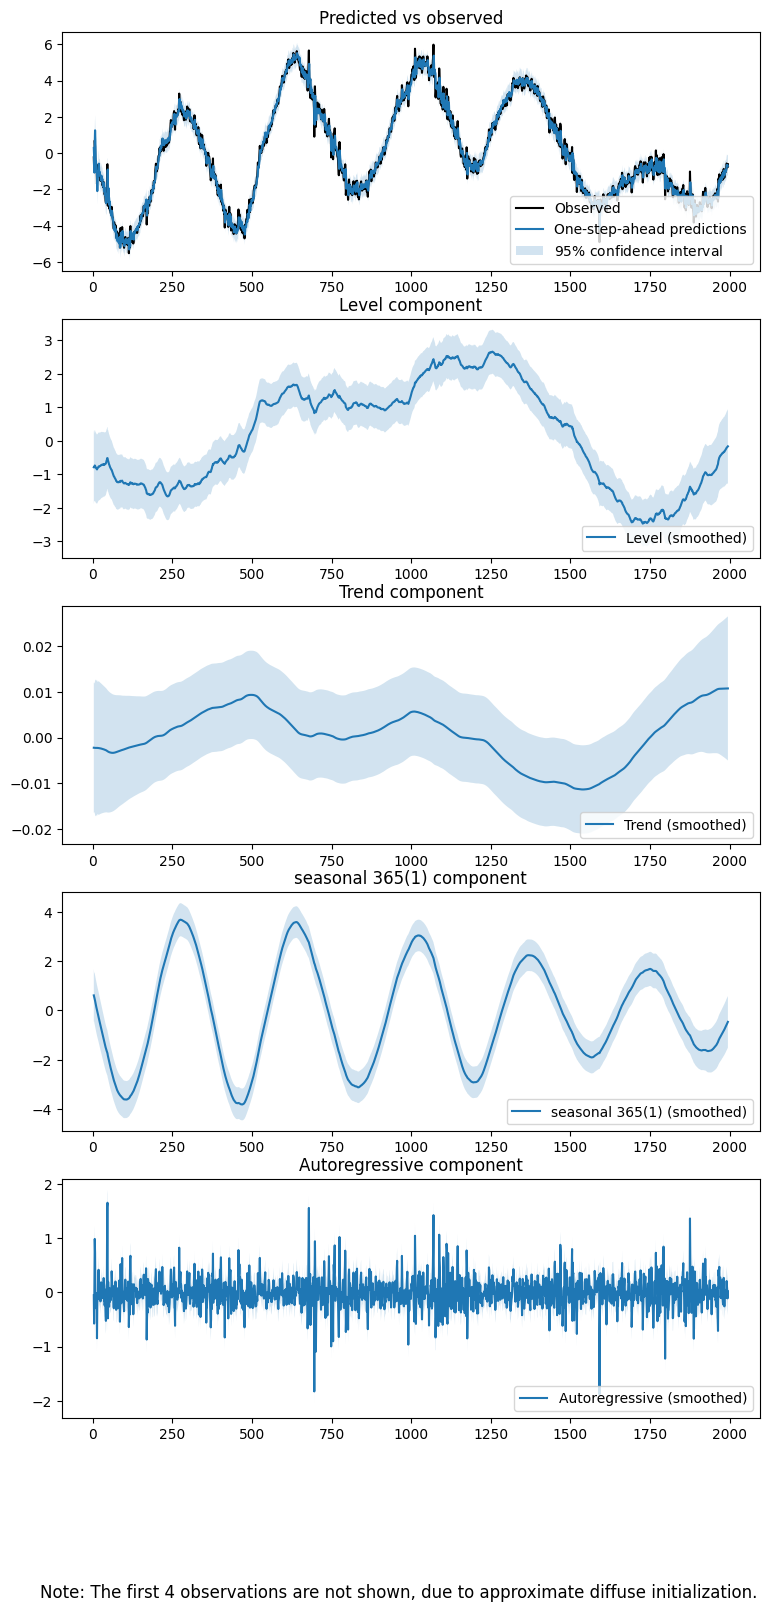

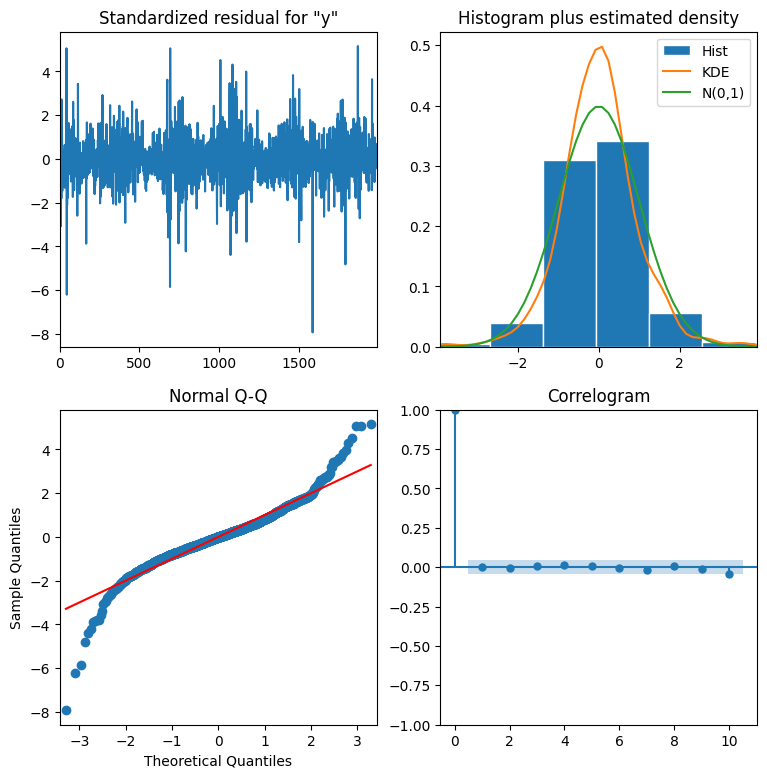

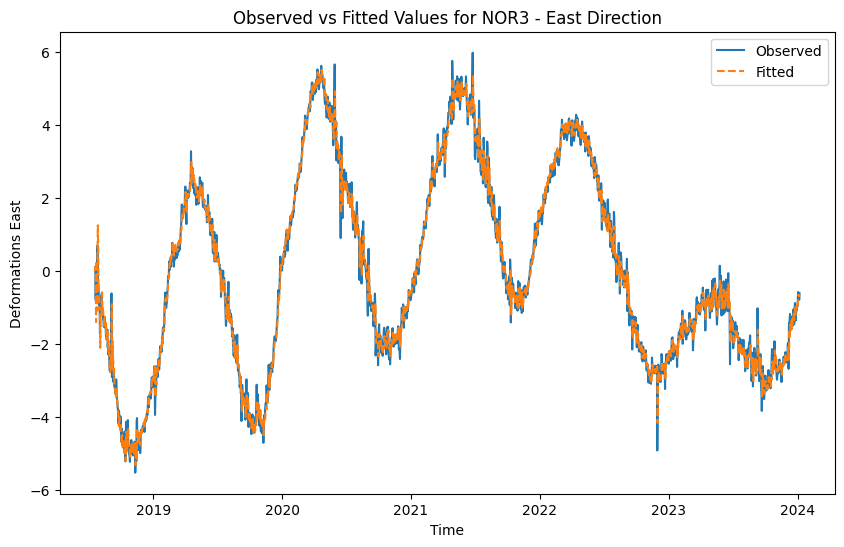

Observation equation covariance matrix (measurement noise) for NOR3 - East:
 [[[8.32495926e-08]]]
State equation covariance matrix (process noise) for NOR3 - East:
 [[[3.74866458e-03]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [5.06808207e-07]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [1.27927062e-03]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [1.27927062e-03]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [6.79642357e-02]]]
Standard deviation (sigma) of the residuals for NOR3 - East: 0.2967963142060565


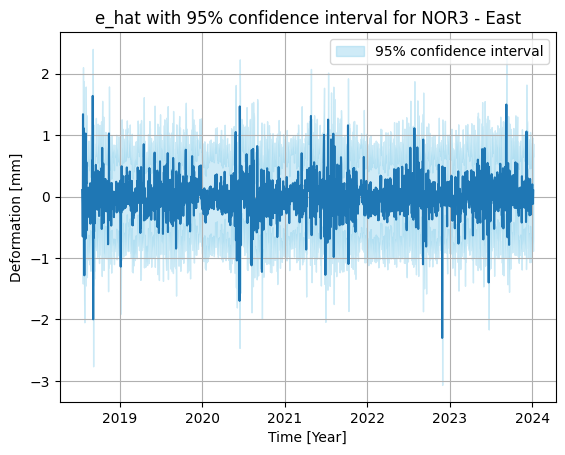

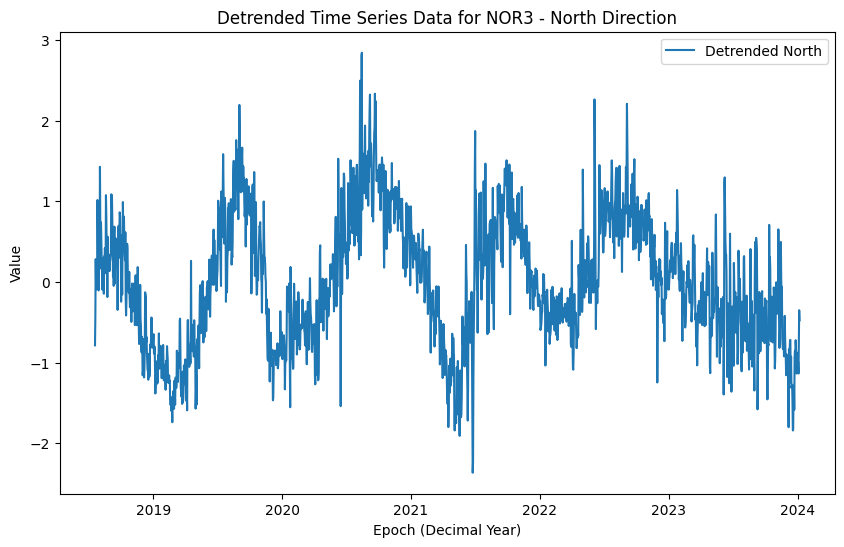

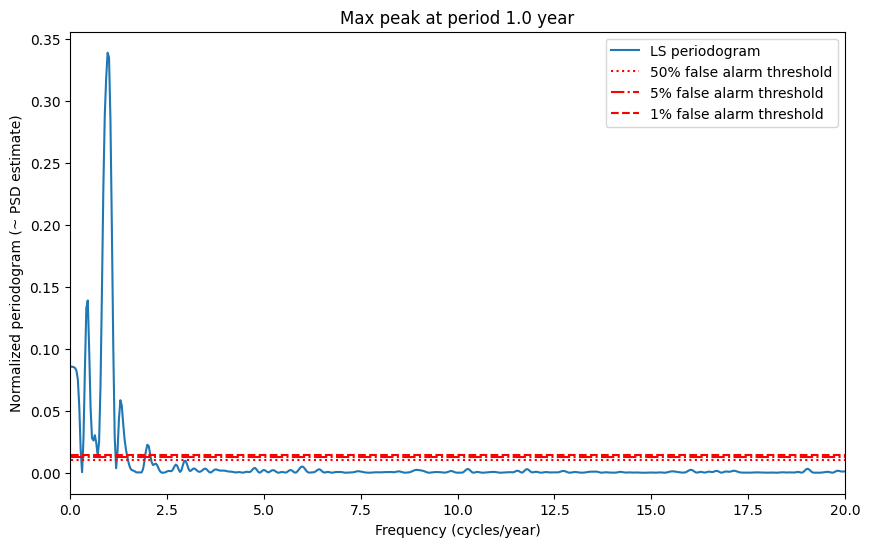

Best period for NOR3 North: 1.0310849379463418 years
Optimization terminated successfully.
         Current function value: 0.309919
         Iterations: 7
         Function evaluations: 684
                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                 1995
Model:                             local linear trend   Log Likelihood                -618.288
                   + stochastic freq_seasonal(365(1))   AIC                           1250.577
                                              + AR(2)   BIC                           1289.752
Date:                                Mon, 10 Jun 2024   HQIC                          1264.964
Time:                                        11:38:54                                         
Sample:                                             0                                         
                                               - 

/Users/lewys/anaconda3/envs/VSP/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


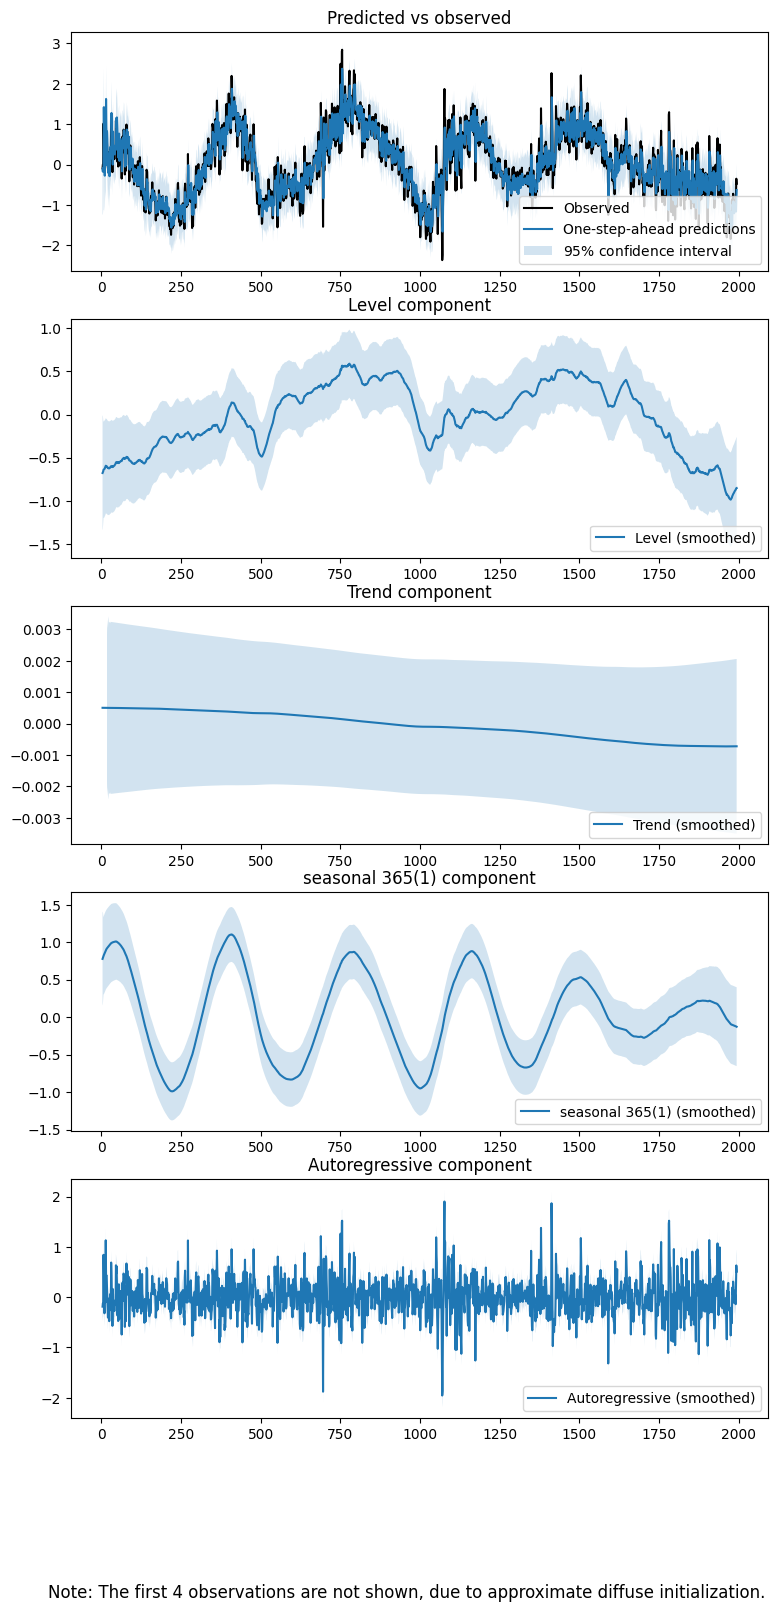

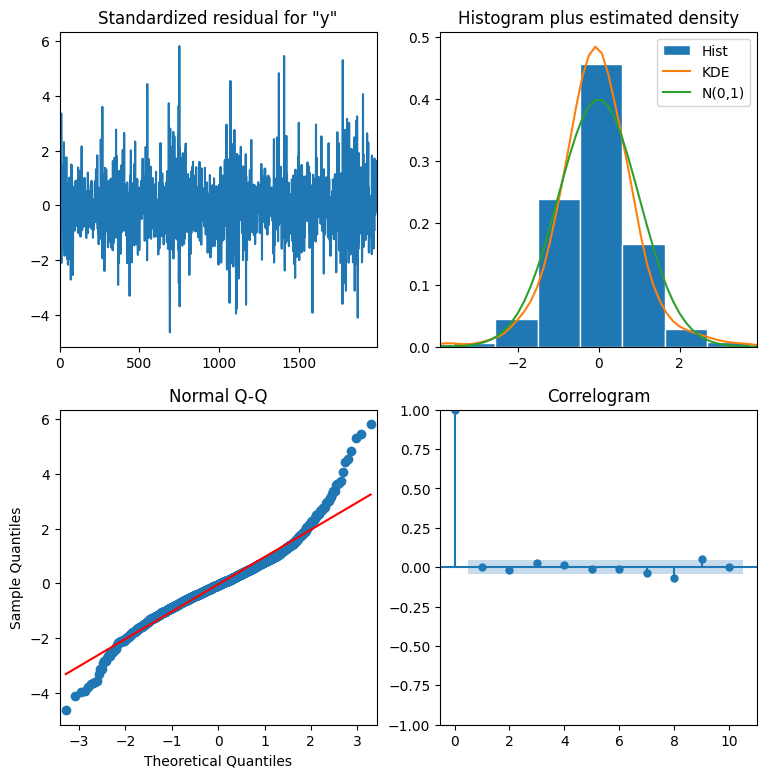

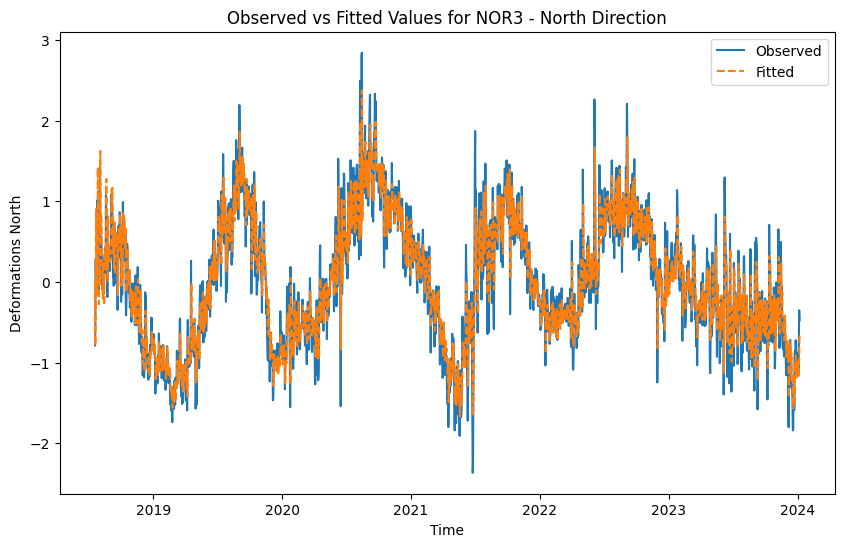

Observation equation covariance matrix (measurement noise) for NOR3 - North:
 [[[1.16894439e-07]]]
State equation covariance matrix (process noise) for NOR3 - North:
 [[[1.70726747e-03]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [2.00721164e-09]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [4.00229796e-04]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [4.00229796e-04]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [9.70844252e-02]]]
Standard deviation (sigma) of the residuals for NOR3 - North: 0.3318312514834967


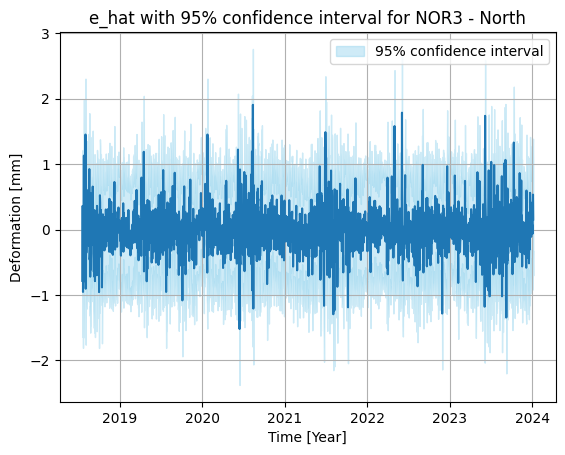

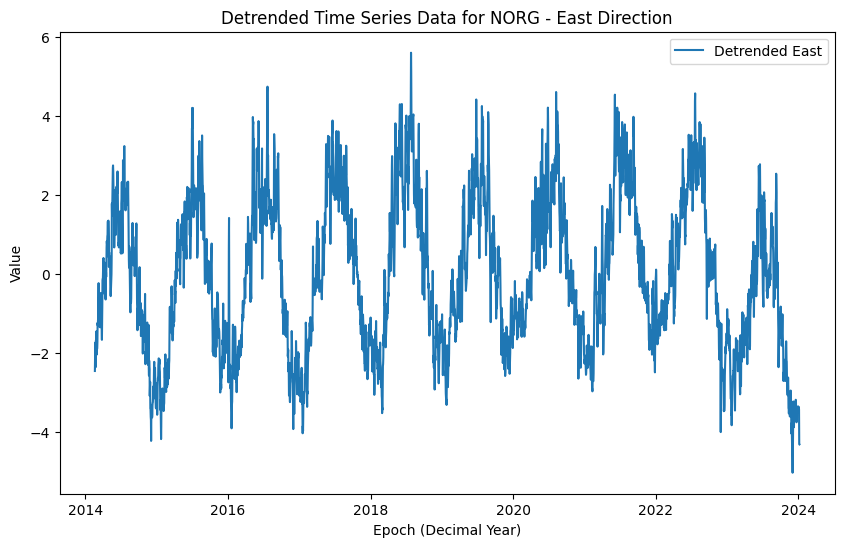

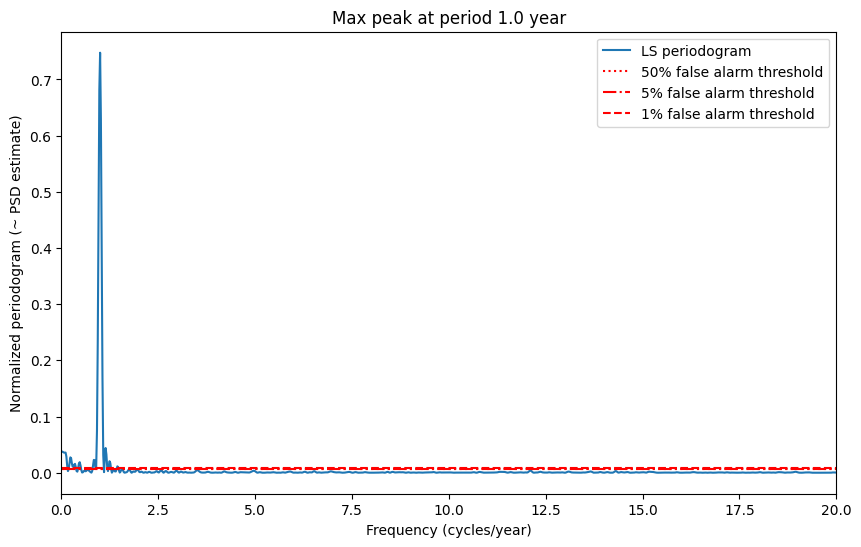

Best period for NORG East: 0.9977945090881438 years
Optimization terminated successfully.
         Current function value: 0.516405
         Iterations: 4
         Function evaluations: 374
                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                 3609
Model:                             local linear trend   Log Likelihood               -1863.706
                   + stochastic freq_seasonal(365(1))   AIC                           3741.412
                                              + AR(2)   BIC                           3784.742
Date:                                Mon, 10 Jun 2024   HQIC                          3756.853
Time:                                        11:38:57                                         
Sample:                                             0                                         
                                               - 3

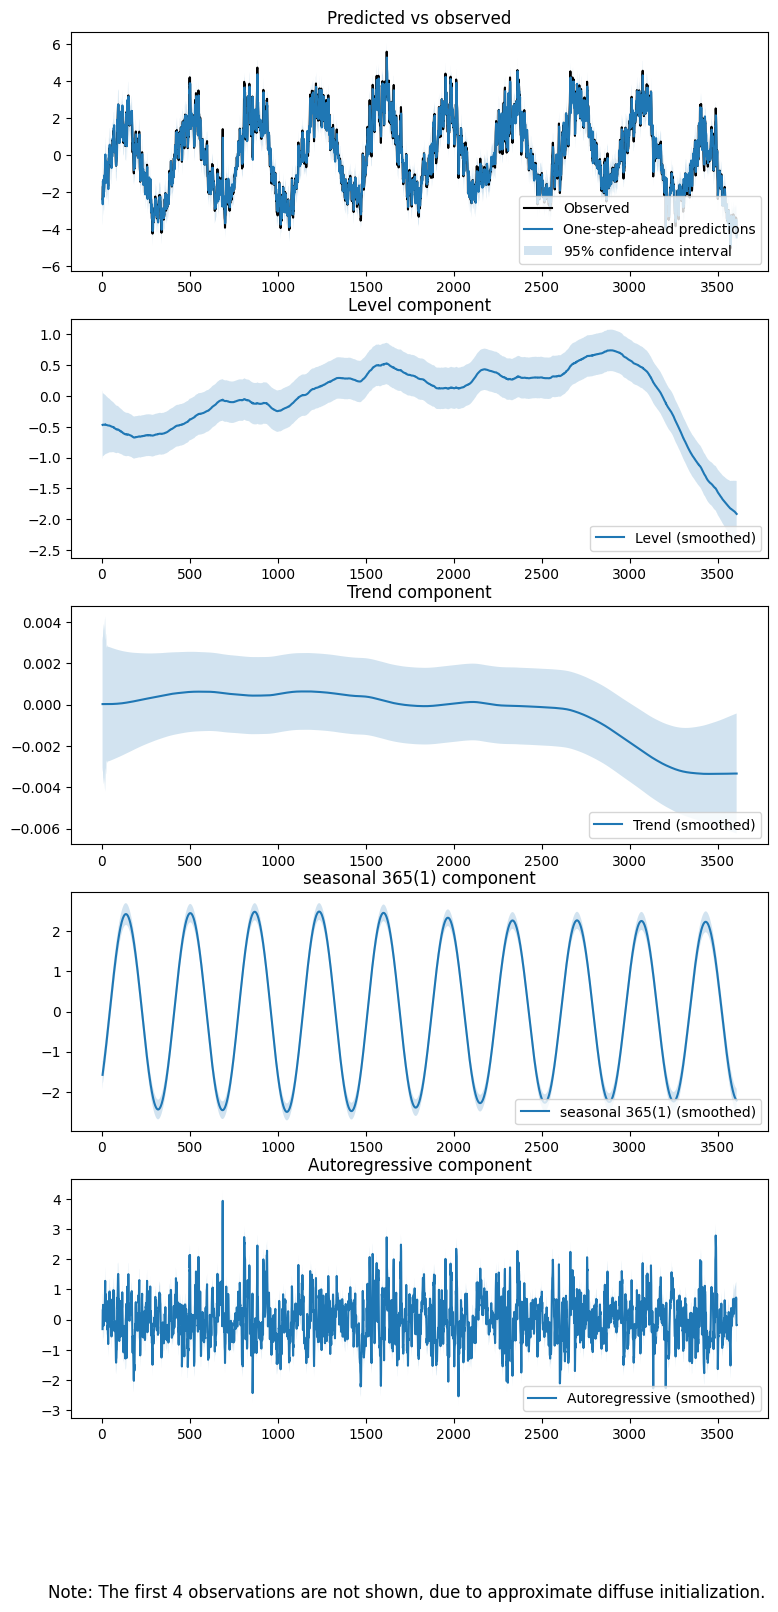

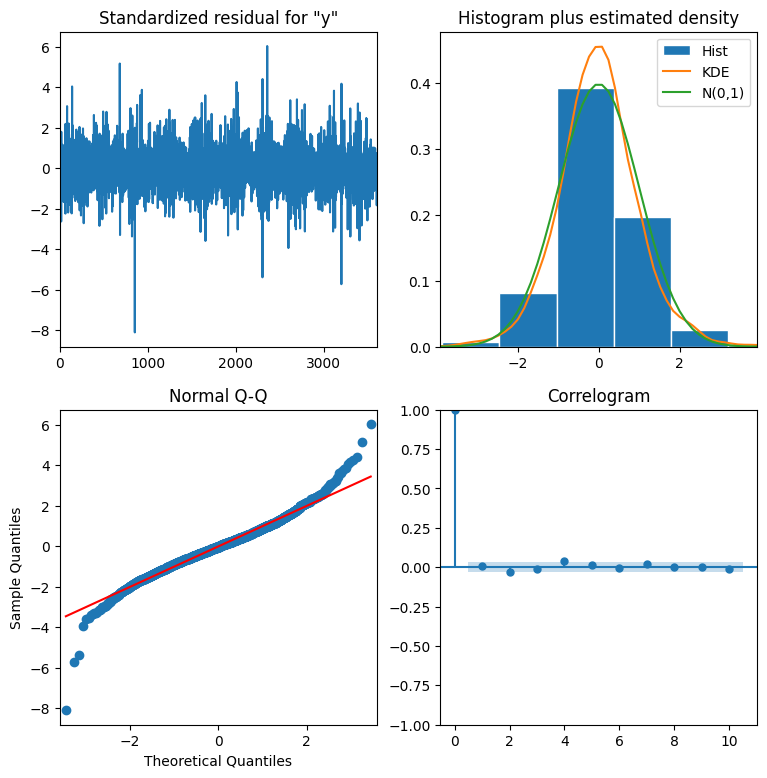

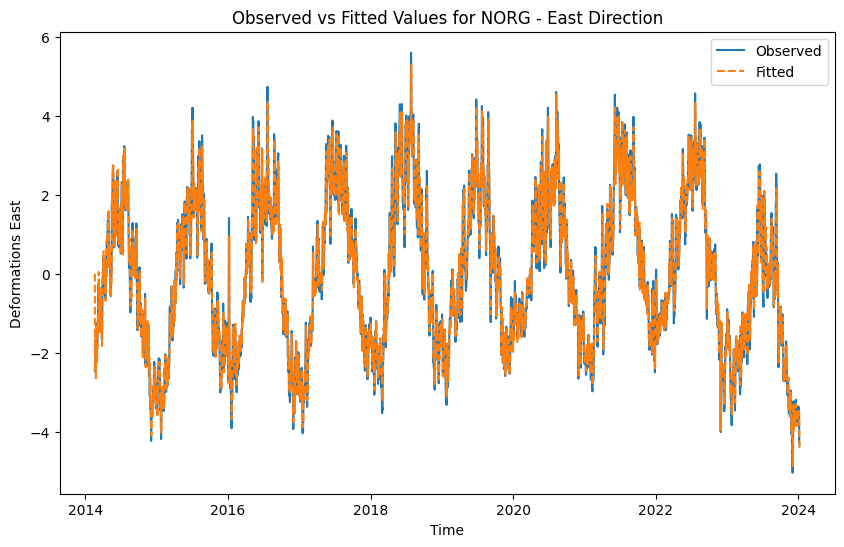

Observation equation covariance matrix (measurement noise) for NORG - East:
 [[[3.73135107e-15]]]
State equation covariance matrix (process noise) for NORG - East:
 [[[6.04507630e-04]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [5.06704313e-09]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [3.56108818e-05]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [3.56108818e-05]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [1.59554270e-01]]]
Standard deviation (sigma) of the residuals for NORG - East: 0.40770681722118907


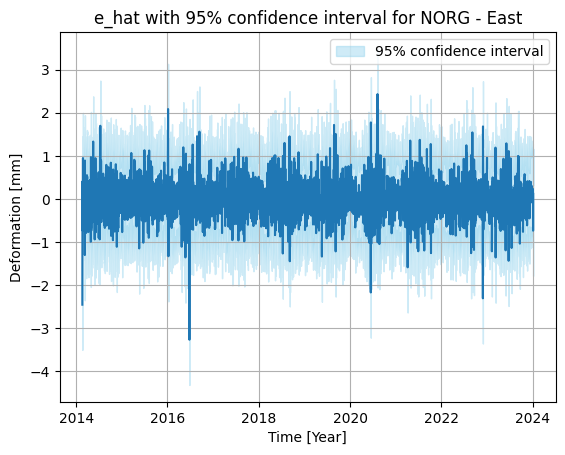

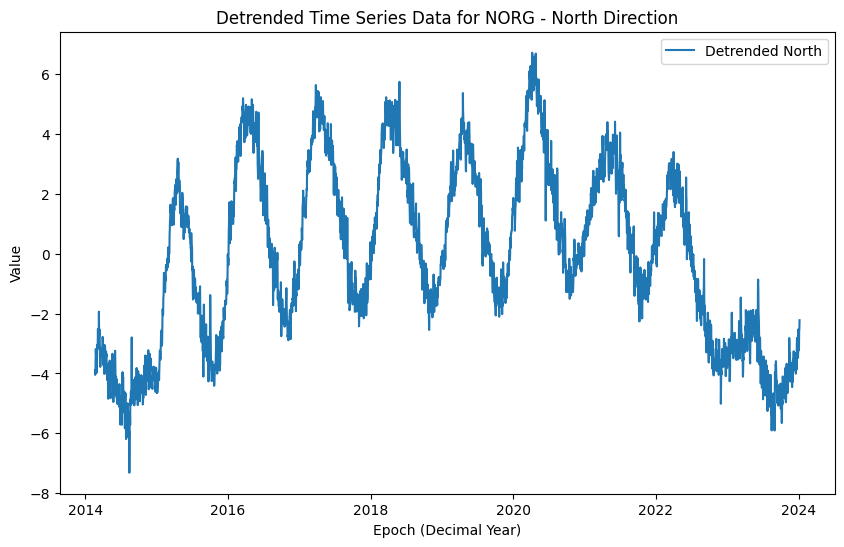

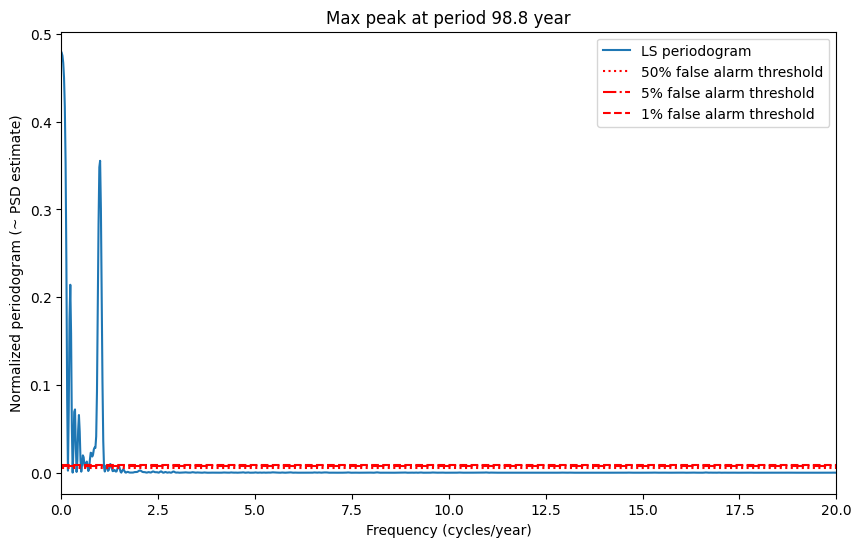

Best period for NORG North: 98.78165639972623 years
Optimization terminated successfully.
         Current function value: 0.411443
         Iterations: 8
         Function evaluations: 735
                                Unobserved Components Results                                 
Dep. Variable:                                      y   No. Observations:                 3609
Model:                             local linear trend   Log Likelihood               -1484.899
                   + stochastic freq_seasonal(365(1))   AIC                           2983.798
                                              + AR(2)   BIC                           3027.129
Date:                                Mon, 10 Jun 2024   HQIC                          2999.239
Time:                                        11:39:00                                         
Sample:                                             0                                         
                                               - 3

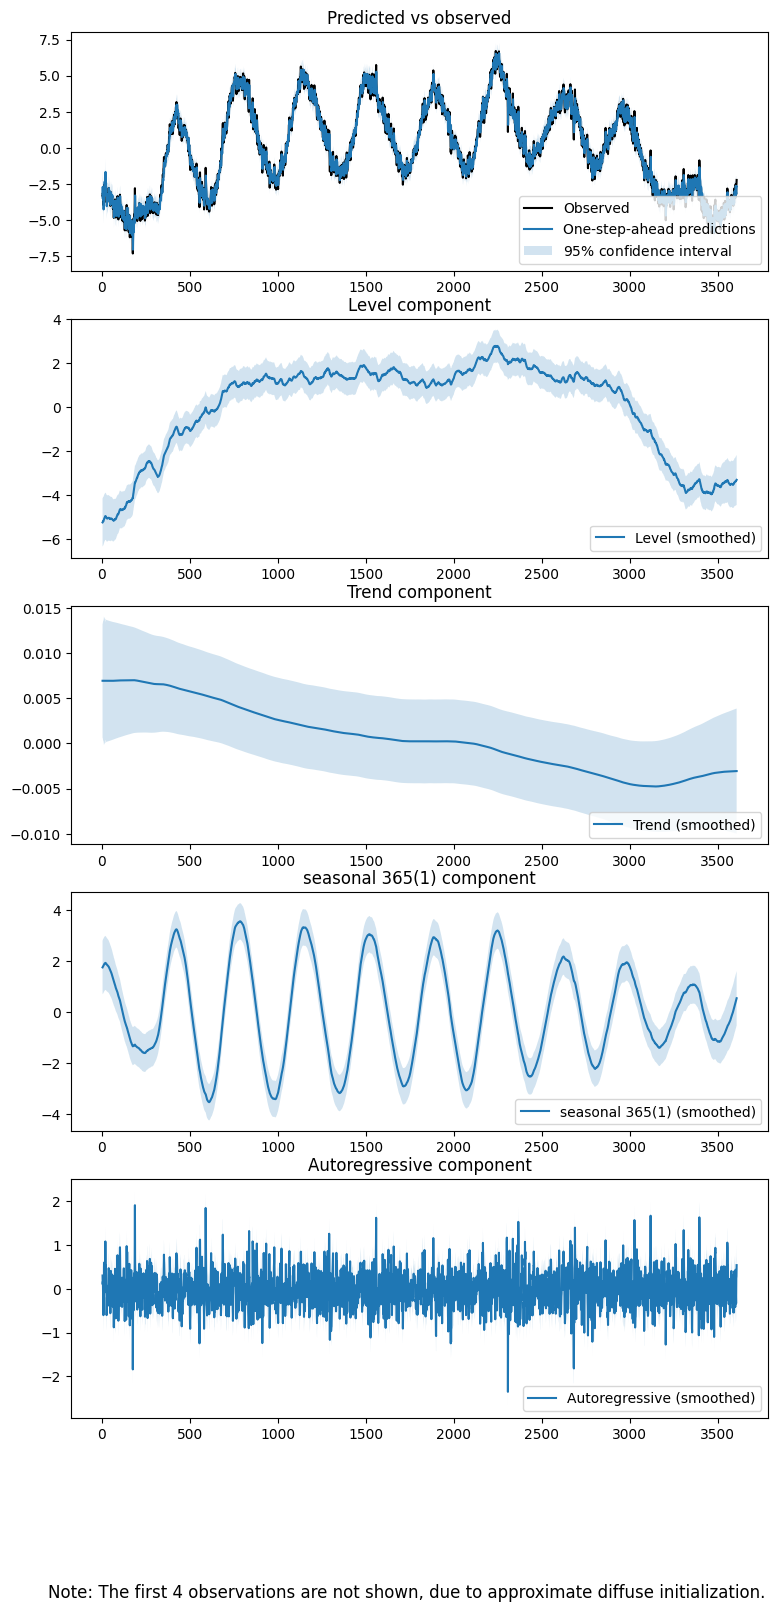

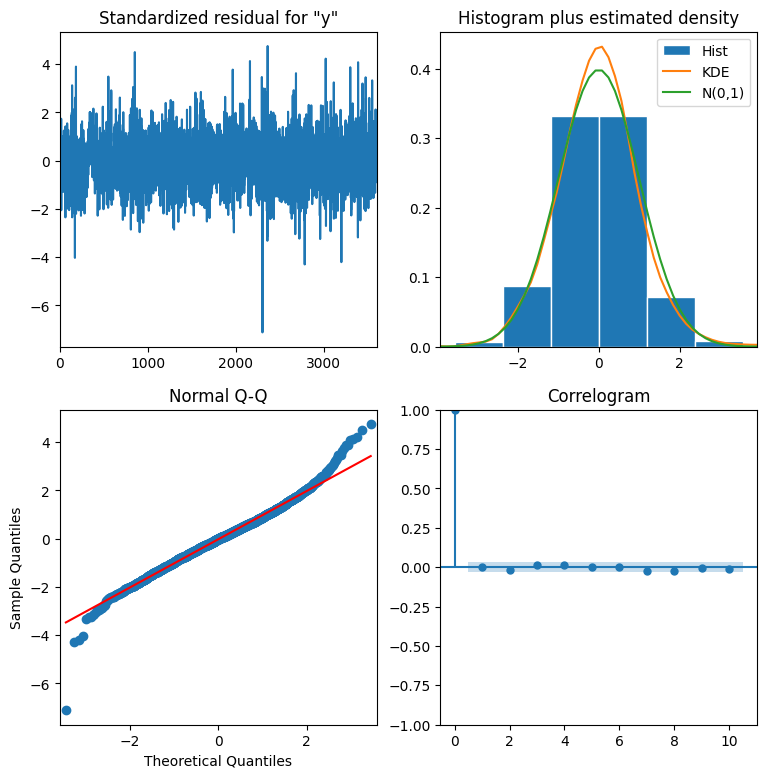

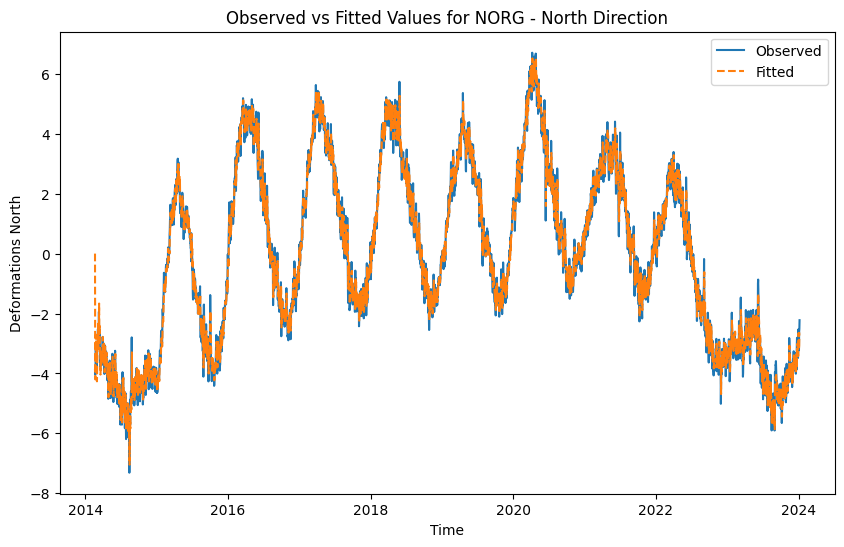

Observation equation covariance matrix (measurement noise) for NORG - North:
 [[[2.24531938e-06]]]
State equation covariance matrix (process noise) for NORG - North:
 [[[5.20885829e-03]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [2.37542969e-08]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [2.05403270e-03]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [2.05403270e-03]
  [0.00000000e+00]]

 [[0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [1.13048956e-01]]]
Standard deviation (sigma) of the residuals for NORG - North: 0.3707867083498263


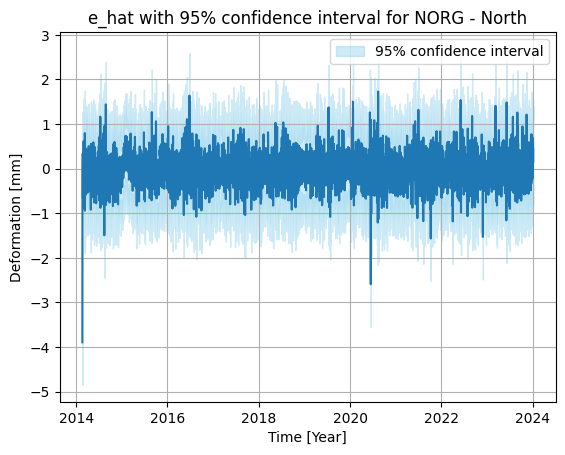

In [42]:

# Define function to analyze East and North direction data for a single station
def analyze_station(station_name, station_index, epochDyear, obsData):
    series_north = obsData[station_index, :, 0]
    series_east = obsData[station_index, :, 1]

    # Create time series DataFrame
    df = pd.DataFrame({'Epoch': epochDyear, 'North': series_north, 'East': series_east})

    # Remove NaN and inf values
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    for direction in ['East', 'North']:
        detrended_data = detrend(df[direction])

        # Plot detrended time series data
        plt.figure(figsize=(10, 6))
        plt.plot(df['Epoch'], detrended_data, label=f'Detrended {direction}')
        plt.xlabel('Epoch (Decimal Year)')
        plt.ylabel('Value')
        plt.title(f'Detrended Time Series Data for {station_name} - {direction} Direction')
        plt.legend()
        plt.show()

        # Use Lomb-Scargle method to find main period peak and plot periodogram
        LS = LombScargle(df['Epoch'], detrended_data)
        frequency, power = LS.autopower(nyquist_factor=1)
        plt.figure(figsize=(10, 6))
        plt.plot(frequency, power, label='LS periodogram')

        # Calculate false alarm probability levels
        false_alarm_probabilities = [0.5, 0.05, 0.01]
        levels = LS.false_alarm_level(false_alarm_probabilities, method='baluev')

        plt.plot(frequency, levels[0] * np.ones(frequency.shape), 'r:', label='50% false alarm threshold')
        plt.plot(frequency, levels[1] * np.ones(frequency.shape), 'r-.', label='5% false alarm threshold')
        plt.plot(frequency, levels[2] * np.ones(frequency.shape), 'r--', label='1% false alarm threshold')

        plt.legend()
        plt.xlabel('Frequency (cycles/year)')
        plt.xlim(0, 20)
        plt.ylabel('Normalized periodogram (~ PSD estimate)')
        plt.title(f'Lomb-Scargle Periodogram of Detrended Time Series for {station_name} - {direction} Direction')

        freq_max = frequency[power.argmax()]
        plt.title(f'Max peak at period {round(1 / freq_max, 1)} year')
        plt.show()

        # Find the period peak
        best_frequency = freq_max
        best_period = 1 / best_frequency
        print(f'Best period for {station_name} {direction}: {best_period} years')

        # Update model settings, add AR(2)
        model_settings_ar2 = {
            'irregular': True,
            'level': True,
            'stochastic_level': True,
            'trend': True,
            'stochastic_trend': True,
            'freq_seasonal': [{'period': 365, 'harmonics': 1}],
            'autoregressive': 2,
        }

        # Define state space model with AR(2)
        ssm_ar2 = sm.tsa.UnobservedComponents(detrended_data, **model_settings_ar2)

        # Fit the model with AR(2)
        ssm_ar2_res = ssm_ar2.fit(method='powell', disp=True)

        # Output the model results with AR(2)
        print(ssm_ar2_res.summary())

        # Plot the model components with AR(2)
        fig = ssm_ar2_res.plot_components(legend_loc='lower right', figsize=(9, 18))
        plt.show()

        # Plot the diagnostics with AR(2)
        ssm_ar2_res.plot_diagnostics(figsize=(9, 9))
        plt.show()

        # Extract fitted values
        fitted_values = ssm_ar2_res.fittedvalues

        plt.figure(figsize=(10, 6))
        plt.plot(df['Epoch'], detrended_data, label='Observed')
        plt.plot(df['Epoch'], fitted_values, label='Fitted', linestyle='--')
        plt.legend()
        plt.title(f'Observed vs Fitted Values for {station_name} - {direction} Direction')
        plt.xlabel('Time')
        plt.ylabel(f'Deformations {direction}')
        plt.show()

        obs_cov_matrix = ssm_ar2_res.filter_results.obs_cov
        print(f"Observation equation covariance matrix (measurement noise) for {station_name} - {direction}:\n", obs_cov_matrix)

        state_cov_matrix = ssm_ar2_res.filter_results.state_cov
        print(f"State equation covariance matrix (process noise) for {station_name} - {direction}:\n", state_cov_matrix)

        residuals = ssm_ar2_res.resid
        sigma = np.std(residuals)
        print(f"Standard deviation (sigma) of the residuals for {station_name} - {direction}:", sigma)

        plt.plot(df['Epoch'], residuals)
        ehat_int = norm.ppf(.995, scale=sigma)
        ehatplus = residuals + ehat_int
        ehatmin = residuals - ehat_int

        plt.fill_between(df['Epoch'], ehatplus, ehatmin, color='skyblue', alpha=0.4, label='95% confidence interval')
        plt.legend()
        plt.title(f'e_hat with 95% confidence interval for {station_name} - {direction}')
        plt.xlabel('Time [Year]')
        plt.ylabel('Deformation [mm]')
        plt.grid()
        plt.show()

# Analyze data for three stations
for station_name in ['RDN1', 'NOR3', 'NORG']:
    station_index = None
    for i, name in enumerate(pntName):
        if name[0] == station_name:
            station_index = i
            break

    if station_index is not None:
        analyze_station(station_name, station_index, epochDyear, obsData)
    else:
        print(f'Station {station_name} not found')
